In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from prediction_script import *
from rdkit.Chem import Draw
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Configure Training and Test Set

In [2]:
df = pd.read_csv('../../data_preparation/output/total_compounds.csv')

seed_val=0
frac=0.95

all_bb1 = unique_bb(df, bb_pos='bb1')
all_bb2 = unique_bb(df, bb_pos='bb2')
all_bb3 = unique_bb(df, bb_pos='bb3')

bb1_train, bb1_test = sample_bb(all_bb1, bb_pos='bb1', frac=frac, seed=seed_val)
bb2_train, bb2_test = sample_bb(all_bb2, bb_pos='bb2', frac=frac, seed=seed_val)
bb3_train, bb3_test = sample_bb(all_bb3, bb_pos='bb3', frac=frac, seed=seed_val)

train, test = train_test_set(df, bb1_train, bb2_train, bb3_train)

bb1_train, bb1_test = update_bbs(train, bb1_train, bb1_test, 'bb1')
bb2_train, bb2_test = update_bbs(train, bb2_train, bb2_test, 'bb2')
bb3_train, bb3_test = update_bbs(train, bb3_train, bb3_test, 'bb3')

bb1_train = calc_pbind(train, bb1_train, bb_pos='bb1')
bb2_train = calc_pbind(train, bb2_train, bb_pos='bb2')
bb3_train = calc_pbind(train, bb3_train, bb_pos='bb3')

In [11]:
bb1_ref = pd.read_csv('../../data_preparation/output/bb1_list.csv').reset_index()
bb2_ref = pd.read_csv('../../data_preparation/output/bb2_list.csv').reset_index()
bb3_ref = pd.read_csv('../../data_preparation/output/bb3_list.csv').reset_index()

In [12]:
bb1_train_ind = match(bb1_train, bb1_ref, bb_pos='bb1')
bb1_test_ind = match(bb1_test, bb1_ref, bb_pos='bb1')

bb2_train_ind = match(bb2_train, bb2_ref, bb_pos='bb2')
bb2_test_ind = match(bb2_test, bb2_ref, bb_pos='bb2')

bb3_train_ind = match(bb3_train, bb3_ref, bb_pos='bb3')
bb3_test_ind = match(bb3_test, bb3_ref, bb_pos='bb3')

### Transform similarity scores into UMAP distances

In [13]:
bb1_sim_3D = np.load('../../similarity_calculation/output/bb1_list.npy')
bb2_sim_3D = np.load('../../similarity_calculation/output/bb2_list.npy')
bb3_sim_3D = np.load('../../similarity_calculation/output/bb3_list.npy')

bb1_dist = dist_mat(bb1_sim_3D)
bb2_dist = dist_mat(bb2_sim_3D)
bb3_dist = dist_mat(bb3_sim_3D)

bb1_coords, bb1_umap = UMAP_dist(bb1_dist[np.ix_(bb1_train_ind, bb1_train_ind)], seed=seed_val)
bb2_coords, bb2_umap = UMAP_dist(bb2_dist[np.ix_(bb2_train_ind, bb2_train_ind)], seed=seed_val)
bb3_coords, bb3_umap = UMAP_dist(bb3_dist[np.ix_(bb3_train_ind, bb3_train_ind)], seed=seed_val)

,Position,top - top dist,top - rand dist
0,1,3.432819,6.882358
1,2,1.115127,10.149671
2,3,5.187574,8.504790


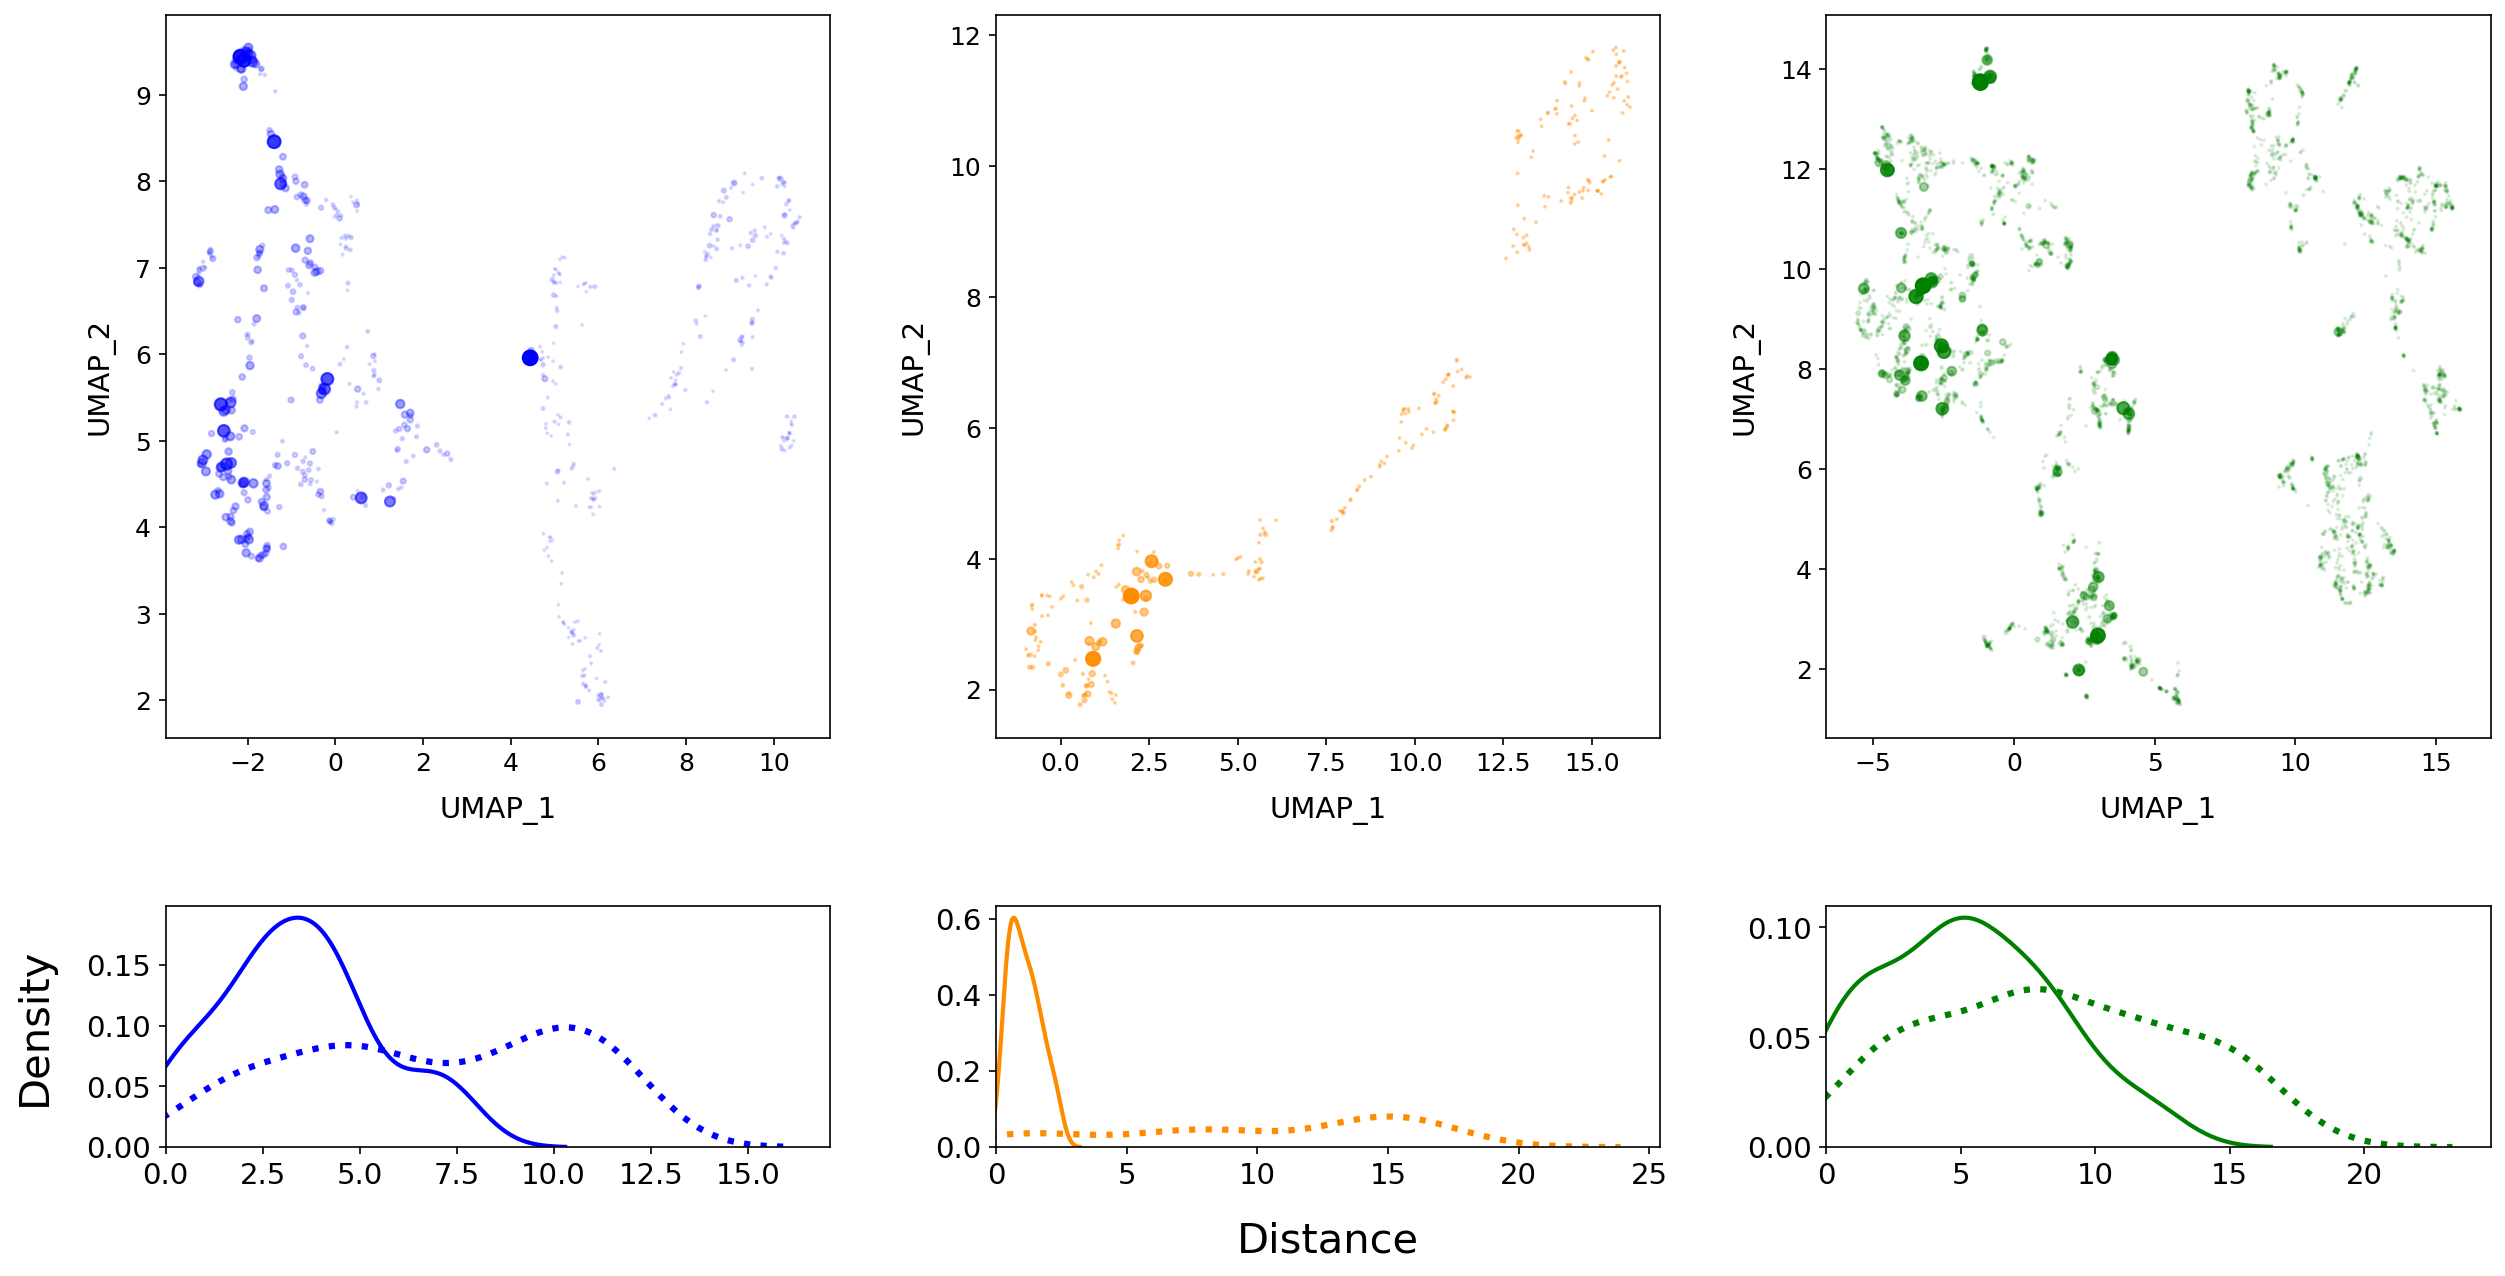

In [14]:
bb1_train, bb2_train, bb3_train = plot_umap(bb1_train, bb2_train, bb3_train, bb1_umap, bb2_umap, bb3_umap)

### Determine optimal HDBSCAN hyperparameters

In [15]:
bb1_train = assign_coords(bb1_train, bb1_coords)
bb2_train = assign_coords(bb2_train, bb2_coords)
bb3_train = assign_coords(bb3_train, bb3_coords)

opt_params_bb1 = optimal_hdbscan(bb1_train)
opt_params_bb2 = optimal_hdbscan(bb2_train)
opt_params_bb3 = optimal_hdbscan(bb3_train)

In [16]:
bb1_clusterer, bb1_cluster_labels = cluster(bb1_train, opt_params_bb1)
bb2_clusterer, bb2_cluster_labels = cluster(bb2_train, opt_params_bb2)
bb3_clusterer, bb3_cluster_labels = cluster(bb3_train, opt_params_bb3)

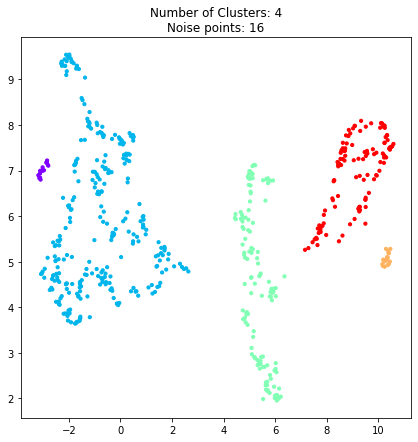

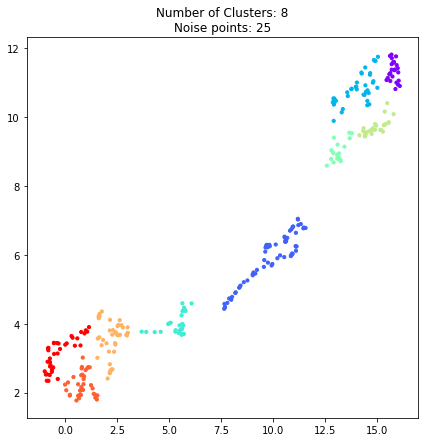

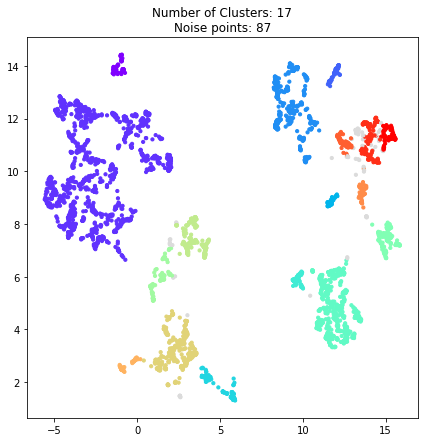

In [17]:
bb1_train = plot_hdbscan(bb1_train, opt_params_bb1, bb1_umap)
bb2_train = plot_hdbscan(bb2_train, opt_params_bb2, bb2_umap)
bb3_train = plot_hdbscan(bb3_train, opt_params_bb3, bb3_umap)

### Predict the cluster assignments for test set building blocks

In [18]:
bb1_test_coords, bb1_cluster, bb1_prob = predict_cluster(bb1_umap, bb1_clusterer, bb1_dist, bb1_train_ind, bb1_test_ind)
bb2_test_coords, bb2_cluster, bb2_prob = predict_cluster(bb2_umap, bb2_clusterer, bb2_dist, bb2_train_ind, bb2_test_ind)
bb3_test_coords, bb3_cluster, bb3_prob = predict_cluster(bb3_umap, bb3_clusterer, bb3_dist, bb3_train_ind, bb3_test_ind)

bb1_test = assign_coords(bb1_test, bb1_test_coords)
bb2_test = assign_coords(bb2_test, bb2_test_coords)
bb3_test = assign_coords(bb3_test, bb3_test_coords)

bb1_test['Cluster'] = bb1_cluster
bb2_test['Cluster'] = bb2_cluster
bb3_test['Cluster'] = bb3_cluster

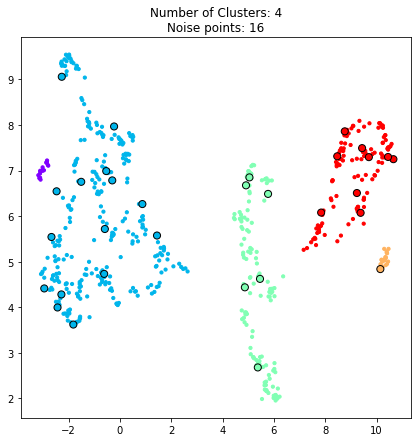

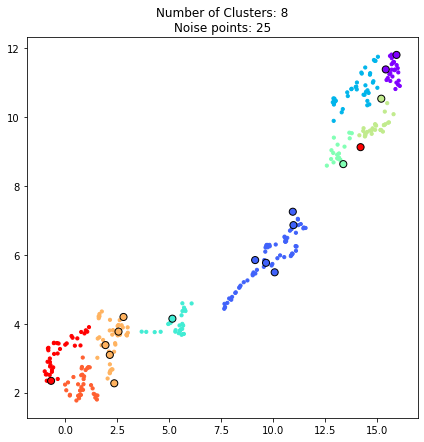

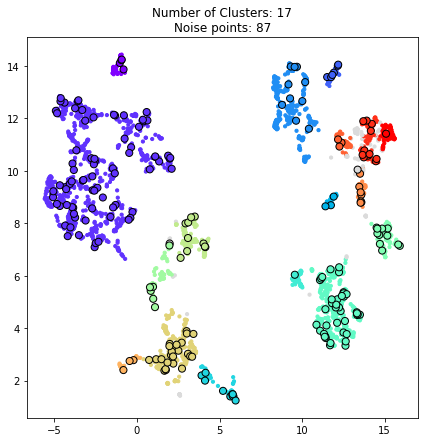

In [19]:
_ = plot_hdbscan(bb1_train, opt_params_bb1, bb1_umap, bb1_test)
_ = plot_hdbscan(bb2_train, opt_params_bb2, bb2_umap, bb2_test)
_ = plot_hdbscan(bb3_train, opt_params_bb3, bb3_umap, bb3_test)

### Estimate P(bind) of test set building blocks

### Create decision tree

In [23]:
train_input = format_data_for_tree(train, bb1_train, bb2_train, bb3_train)
tree_classifier = create_tree(train_input, seed=seed_val, depth=5)
train_features = train_input[['bb1_Cluster', 'bb2_Cluster', 'bb3_Cluster', 'P(bind)_1', 'P(bind)_2', 'P(bind)_3']]

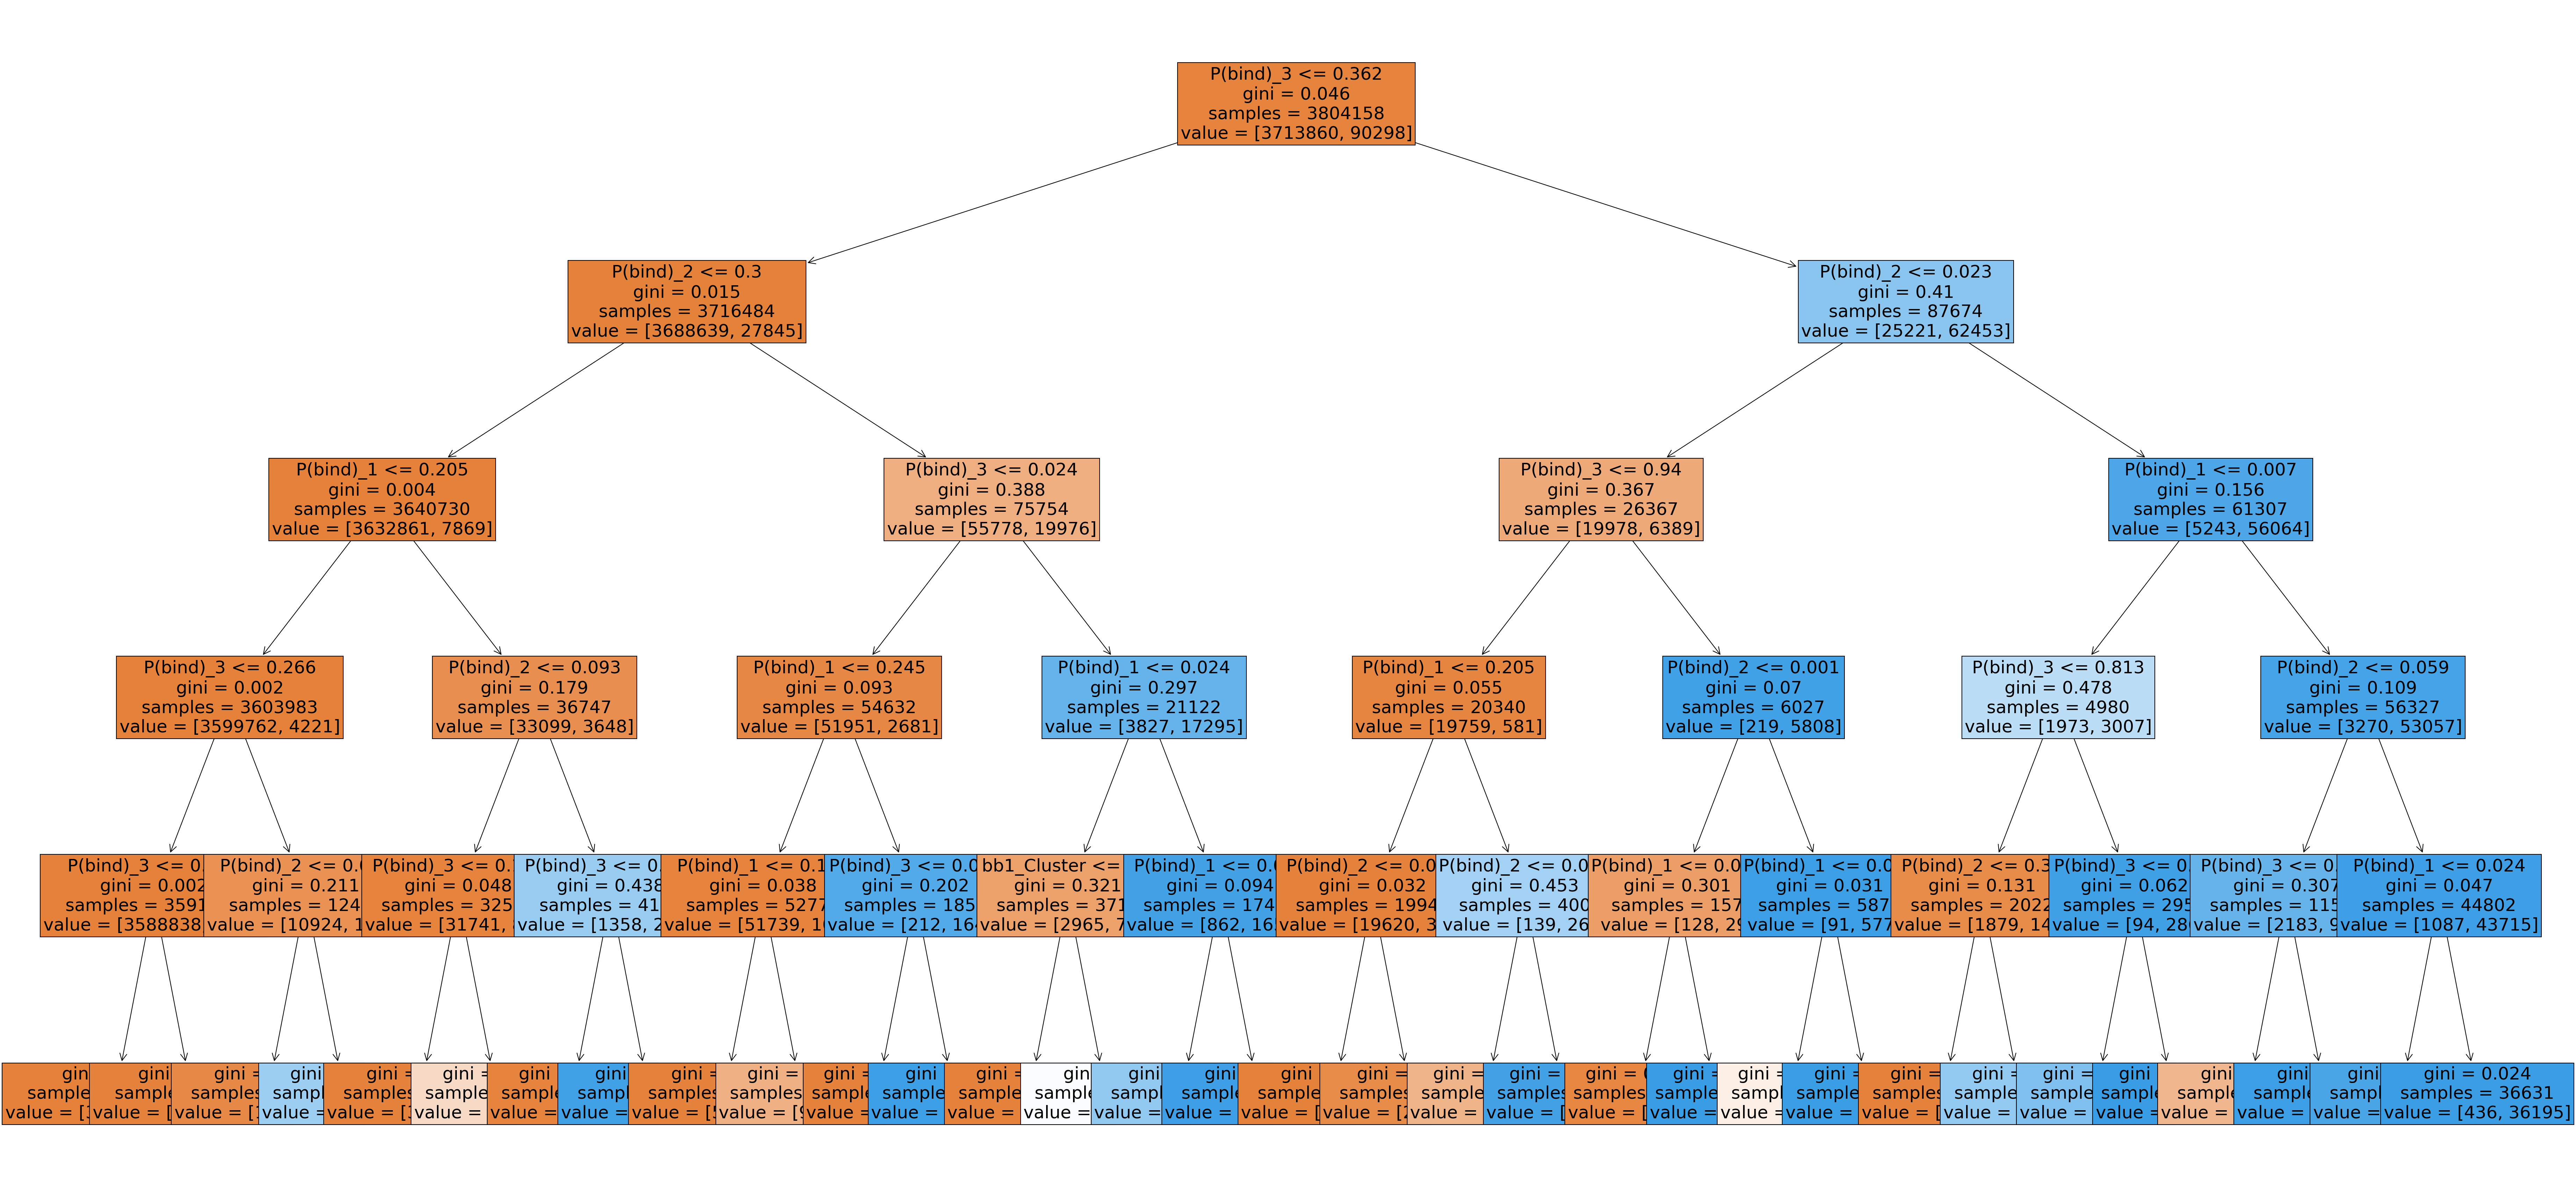

In [64]:
fig, axs = plt.subplots(figsize=(60, 30), dpi=150)
feature_names = ['bb1_Cluster', 'bb2_Cluster', 'bb3_Cluster',
                 'P(bind)_1', 'P(bind)_2', 'P(bind)_3']
class_names = ['bind', 'nonbind']
tree.plot_tree(tree_classifier, feature_names=feature_names, filled=True, ax=axs, fontsize=24)
fig.savefig('tree_image.png')
plt.show()

### Evaluate decision tree performance

In [26]:
# Training performance
train_pred = tree_classifier.predict(train_features)
print(f"Train precision: {precision_score(train_input['bind'], train_pred):.3f}")
print(f"Train recall: {recall_score(train_input['bind'], train_pred):.3f}")

Train precision: 0.960
Train recall: 0.926


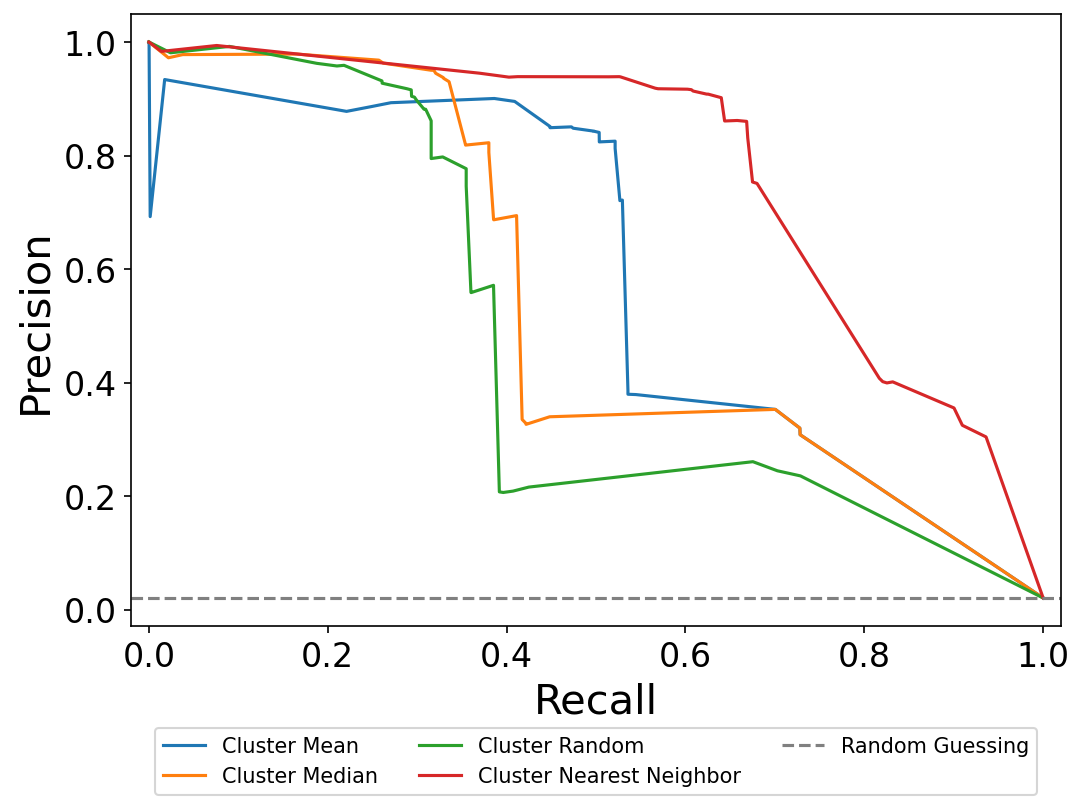

In [45]:
method = ['mean', 'med', 'crand', 'cluster_nn']
auc_values = pd.DataFrame(columns=method)
fig, axs = plt.subplots(dpi=150, figsize=(8,6))
vals = []
for met in method:
    bb1_test[f'{met}'] = get_test_pred(bb1_test, 'bb1', bb1_ref, bb1_train, bb1_train_ind, bb1_dist, how=met, seed=seed_val)
    bb2_test[f'{met}'] = get_test_pred(bb2_test, 'bb2', bb2_ref, bb2_train, bb2_train_ind, bb2_dist, how=met, seed=seed_val)
    bb3_test[f'{met}'] = get_test_pred(bb3_test, 'bb3', bb3_ref, bb3_train, bb3_train_ind, bb3_dist, how=met, seed=seed_val)

    bb1_mod = bb1_test[['bb1', f'{met}', 'X', 'Y', 'Cluster']].rename(columns={f'{met}': 'P(bind)'})
    bb2_mod = bb2_test[['bb2', f'{met}', 'X', 'Y', 'Cluster']].rename(columns={f'{met}': 'P(bind)'})
    bb3_mod = bb3_test[['bb3', f'{met}', 'X', 'Y', 'Cluster']].rename(columns={f'{met}': 'P(bind)'})

    bb1_comb = pd.concat([bb1_train, bb1_mod])
    bb2_comb = pd.concat([bb2_train, bb2_mod])
    bb3_comb = pd.concat([bb3_train, bb3_mod])

    test_input = format_data_for_tree(test, bb1_comb, bb2_comb, bb3_comb)
    test_prob = predict_binding(test_input, tree_classifier)
    p,r,t = precision_recall_curve(test_input['bind'], test_prob)
    
    inds = pd.merge(test_input[['structure']], test[['structure']].reset_index().reset_index(), on='structure', how='left')['level_0']
    test[f'{met}_prob'] = np.zeros(len(test_prob))
    test[f'{met}_prob'].iloc[inds] = test_prob
    vals.append(auc(r,p))
    axs.plot(r,p, label=f'{met}')

auc_values.loc[0] = vals

box = axs.get_position()
axs.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=False, ncol=3, facecolor='white')

labels = ['Cluster Mean', 'Cluster Median', 'Cluster Random', 'Cluster Nearest Neighbor', 'Random Guessing']
axs.axhline(y=np.mean(test_input['bind']), color='gray', linestyle='dashed')
axs.set_xlabel('Recall', fontsize=20)
axs.set_ylabel('Precision', fontsize=20)
axs.tick_params(labelsize=16)
axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, labels=labels, facecolor='white')
axs.set_xlim([-0.02, 1.02])
#fig.savefig('figure_9.png')
plt.show()

In [44]:
auc_values

,mean,med,crand,cluster_nn
0,0.586364,0.539984,0.46931,0.778093


### Identify promising out-of-sample compounds 

In [58]:
# Choose holdout compounds that are predicted to be likely binders
prob_thresh = 0.9
test_sample = test.loc[test['cluster_nn_prob'] > prob_thresh][['bb1', 'bb2', 'bb3', 'structure']]
test_comb = pd.merge(test_sample, bb1_comb[['bb1', 'Cluster']], on='bb1').rename(columns={'Cluster': 'bb1_Cluster'})\
    .merge(bb2_comb[['bb2', 'Cluster']], on='bb2').rename(columns={'Cluster': 'bb2_Cluster'})\
    .merge(bb3_comb[['bb3', 'Cluster']], on='bb3').rename(columns={'Cluster': 'bb3_Cluster'})
test_comb['code'] = [(x,y,z) for x,y,z in zip(test_comb['bb1_Cluster'], test_comb['bb2_Cluster'], test_comb['bb3_Cluster'])]
test_comb[['structure', 'code']]

,structure,code
0,CC(C)CCCCCN(C)C(=O)CCn1ccc(C(=O)NCCC(c2ccccc2)...,"(1, 6, 0)"
1,CC(C)CCCCCN(C)C(=O)c1ncc(C(=O)NCCC(c2ccccc2)c2...,"(1, 6, 0)"
2,CN(CCc1ccncc1)C(=O)c1ncc(C(=O)NCCC(c2ccccc2)c2...,"(1, 6, 0)"
3,CCCc1nc(CN(C)C(=O)c2ncc(C(=O)NCCC(c3ccccc3)c3c...,"(1, 6, 0)"
4,Cc1cc2ccccc2n1CCN(C)C(=O)c1ncc(C(=O)NCCC(c2ccc...,"(1, 6, 0)"
...,...,...
7908,CCc1cccc(NC(=O)c2ccc3c(c2)C(CC(=O)N(C)Cc2ccc(F...,"(1, 6, 11)"
7909,Cc1nc2c(NC(=O)c3ccc4c(c3)C(CC(=O)N(C)Cc3ccc(F)...,"(1, 6, 9)"
7910,CN(Cc1ccc(F)cc1Cl)C(=O)CC1CCCc2ccc(C(=O)Nc3ccc...,"(1, 6, 11)"
7911,Cc1c(NC(=O)c2ccc3c(c2)C(CC(=O)N(C)Cc2ccc(F)cc2...,"(1, 6, -1)"


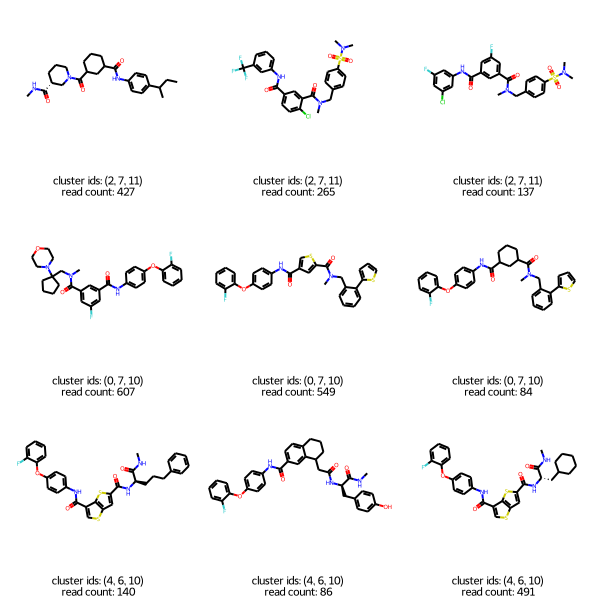

In [59]:
# Select a number of cluster combinations to select building blocks from
N_combos = 3
top_test_combos = test_comb.groupby(['code'], as_index=False)['structure'].count().sort_values(by='structure', ascending=False)
selected_combos = top_test_combos.loc[top_test_combos['structure'] > 1].sample(n=N_combos, random_state=0)['code']

struct = []
reads = []
clusters = []
for comb in selected_combos:
    structures = test_comb.loc[test_comb['code'] == comb].sample(n=3, random_state=10)['structure']
    mols = [Chem.MolFromSmiles(smi) for smi in structures]
    rc = test.loc[test['structure'].isin(structures)]
    struct.append(mols)
    reads.append(list(rc['read_count']))
    clusters.append([comb]*N_combos)


# Display representative compounds from productive cluster combinations
all_structs = [item for sublist in struct for item in sublist]
all_reads = [str(item) for sublist in reads for item in sublist]
all_clusters = [item for sublist in clusters for item in sublist]
labels = [f"cluster ids: {x}\nread count: {y}" for x,y in zip(all_clusters, all_reads)]
img = Draw.MolsToGridImage(all_structs, molsPerRow=3, legends=labels, returnPNG=False)
display(img)

,structure,read_count,bb1,bb2,bb3,bb1_iso,bb2_iso,bb3_iso,mean_prob,med_prob,crand_prob,cluster_nn_prob,bind
1956,CCc1csc(CN(C)C(=O)C2CC3(C2)C(C(=O)NCCC(c2ccccc...,275,CCC1=CSC(CN)=N1,C1C(CC12C(C2(F)F)C(=O)O)C(=O)O,NCCC(C1=CC=CC=C1)C1=CC=CC=C1,CCc1csc(n1)CN,C1C(CC12C(C2(F)F)C(=O)O)C(=O)O,c1ccc(cc1)C(CCN)c2ccccc2,0.988098,0.984646,0.992561,0.992561,1
8554,CN(Cc1ccc(F)cc1Cl)C(=O)c1cc2cc(C(=O)NCCC(c3ccc...,764,NCC1=C(Cl)C=C(F)C=C1,Cn1c(cc2c1ncc(c2)C(=O)O)C(=O)O,NCCC(C1=CC=CC=C1)C1=CC=CC=C1,c1cc(c(cc1F)Cl)CN,Cn1c(cc2c1ncc(c2)C(=O)O)C(=O)O,c1ccc(cc1)C(CCN)c2ccccc2,0.984646,0.984646,0.984646,0.984646,1
14213,CCCc1nc(CN(C)C(=O)c2ccc(C(=O)NCCC(c3ccc(F)cc3)...,204,CCCC1=NC(CN)=CS1,c1cc(ncc1C(=O)O)C(=O)O,NCCC(C1=CC=C(F)C=C1)C1=CC=CO1,CCCc1nc(cs1)CN,c1cc(ncc1C(=O)O)C(=O)O,c1cc(oc1)C(CCN)c2ccc(cc2)F,0.992561,0.992561,0.992561,0.992561,1
986474,CC(C)CCCCCN(C)C(=O)C1CCCC(C(=O)NCC2(c3cccc(F)c...,149,CC(C)CCCCCN,C1CC(CCC(C1)C(=O)O)C(=O)O,NCC1(C2=CC(F)=CC=C2)CCCC1,CC(C)CCCCCN,C1CC(CCC(C1)C(=O)O)C(=O)O,c1cc(cc(c1)F)C2(CCCC2)CN,0.977463,0.694394,0.017264,0.977463,1


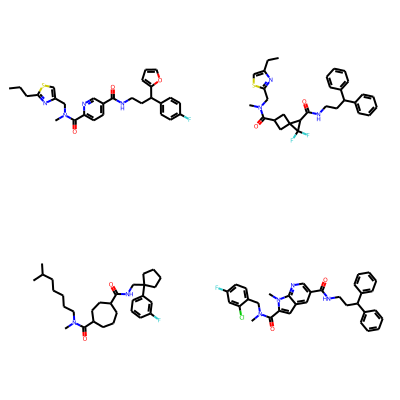

In [63]:
display(get_test_binders(N=3, cluster_ids=(1,6,0), seed=5))

### Export data

In [16]:
#pickle.dump(tree_classifier, open('tree_classifier.pkl', 'wb'))
#pickle.dump(auc_values, open('auc_curve.pkl', 'wb'))
#test.to_csv('test_pred.csv', index=False)
#bb1_test.to_csv('bb1_pred.csv', index=False)
#bb2_test.to_csv('bb2_pred.csv', index=False)
#bb3_test.to_csv('bb3_pred.csv', index=False)